In [115]:
import scipy.io as sio
from scipy.signal import welch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import operator
from functools import reduce
import pandas as pd
import pylab

%matplotlib inline
pylab.rcParams['figure.figsize'] = (18, 8)

Calculamos la máxima frecuencia de sampleo necesaria para no perder información

In [102]:
test = sio.loadmat('dataset/P01.mat')
# epoch, electrodo, muestra
data = test['data']
cant_muestras = len(data[0, 0])
cant_electrodos = len(data[0])
long_epoch = 0.8  # segundos
frecuencia_de_sampleo = cant_muestras / long_epoch / 2 # hertz

In [208]:
electrodos = [8, 44, 80, 131, 185]

frecuencias, _ = welch(data[0, 0], fs=frecuencia_de_sampleo)

def heatmap(desde=0, hasta=cant_muestras):
    epochs = []
    for epoch in range(len(data)):
        poderes_espectrales = []
        for electrodo in electrodos:
            frecuencias, poder_espectral = welch(data[epoch, electrodo][desde:hasta], fs=frecuencia_de_sampleo)
            poderes_espectrales.append(np.array(poder_espectral))

        matriz = np.stack(poderes_espectrales)
        medias_de_poderes_espectrales = np.median(matriz, axis=0)
        epochs.append(np.log(medias_de_poderes_espectrales))

    dataframe = pd.DataFrame(epochs, columns=frecuencias)
    sns.heatmap(dataframe.transpose())

/usr/lib/python3.6/site-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


a.1) Calcular la media entre los electrodos 8, 44, 80, 131 y 185 (el primer electrodo es el 0) y realizar una figura que muestre las frecuencias en el eje Y, los epochs en el eje X, y la potencia usando una escala de color como en el ejemplo:

/usr/lib/python3.6/site-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


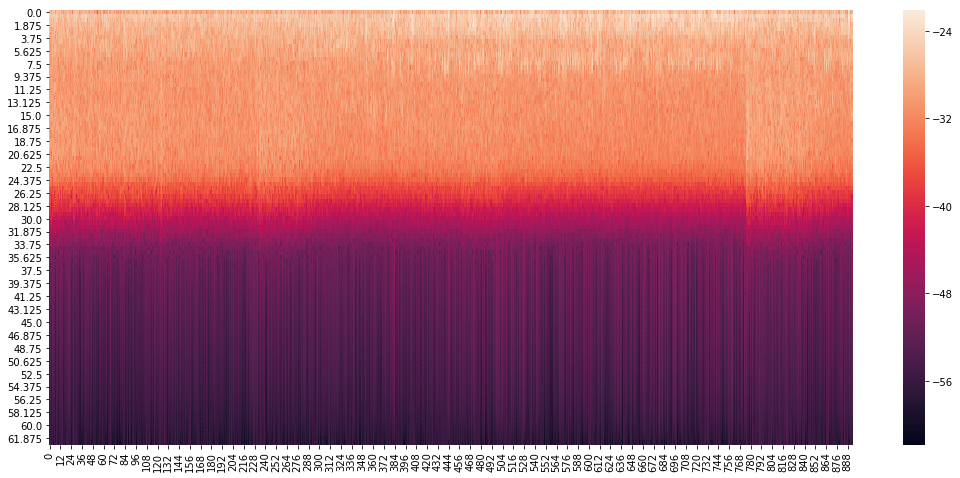

In [209]:
heatmap()

a.2) Calcular la potencia media (entre epochs) para cada frecuencia y graficar la potencia en funcion de la frecuencia para cada canal, como en el ejemplo:

/usr/lib/python3.6/site-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


(0, 12)

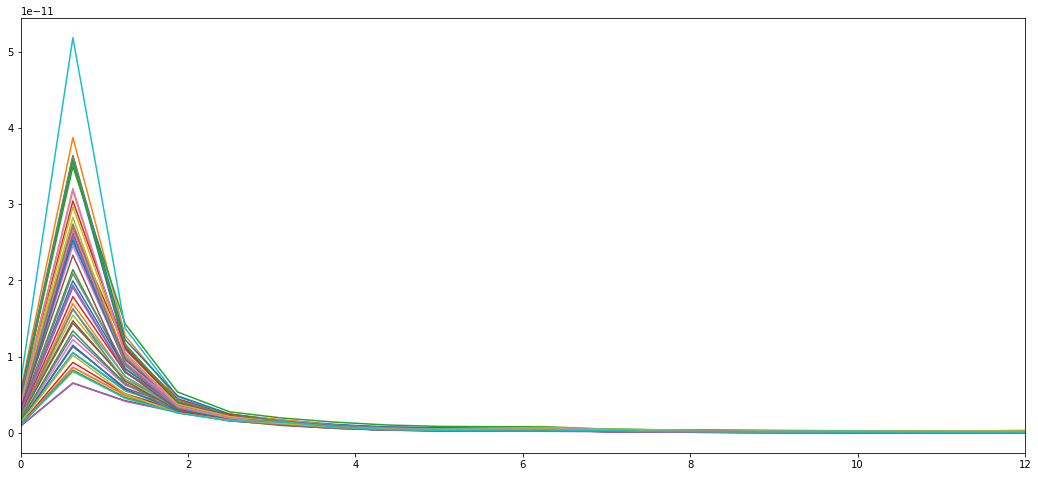

In [210]:
def potencia_media_por_frecuencia(electrodo=0):
    epochs = []
    for epoch in range(len(data)):
        frecuencias, poder_espectral = welch(data[epoch, electrodo], fs=frecuencia_de_sampleo)
        epochs.append(poder_espectral)
    
    # matriz donde las filas son epochs, las columnas frecuencias y los valores poderes espectrales
    matriz = np.stack(epochs)
    medias_de_poderes_espectrales = np.median(matriz, axis=0)
    plt.plot(frecuencias, medias_de_poderes_espectrales)

for electrodo in range(50):
    potencia_media_por_frecuencia(electrodo)
    
plt.xlim(0, 12)    # set the xlim to xmin, xmax